In [309]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter

import eli5

from pprint import pprint
from spacy import displacy
from collections import Counter
import en_core_web_sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# dataset taken from: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/version/4#ner_dataset.csv
raw_data = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")

# "Tag" column uses:
#   1) IOB-2 format:
#     I: word is inside of a chunk
#     O: word is outside of a chunk
#     B: word is at tge beginning of a chunk
#     S: word is a single-word chunk
#     E: word is at end of chunk word
#   2) Entities:
#     geo: Geographical Entity
#     org: Organization
#     per: Person
#     gpe: Geopolitical Entity
#     tim: Time indicator
#     art: Artifact
#     eve: Event
#     nat: Natural Phenomenon
# "POS" column uses POS (Part of Speech Tagging)

# use a subset of the data due to memory constraints
raw_data = raw_data[:30000]

In [3]:
# fill NaNs
data = raw_data.fillna(method='ffill')

In [4]:
# create "x" of training data by removing the "y" column ("Tag") from the dataset
x = data.drop('Tag', axis=1)

# print(x)

# DictVectorizer transformer turns lists of mappings (dict-like objects) of feature names 
# to feature values into Numpy arrays or scipy.sparse matrices for use with 
# scikit-learn estimators.
dv = DictVectorizer(sparse=False)
x = dv.fit_transform(x.to_dict('records'))

# create training data "y"
y = data.Tag.values

# select "classes"
classes = np.unique(y).tolist()

In [5]:
# spliting dataset into train and test
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

classes_without_o = list(set(y_train) - {'O'})

# classification accuracy report
cr = dict()

In [7]:
%%time
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

model_sgd = SGDClassifier()
model_sgd.partial_fit(x_train, y_train, classes)

CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 4.05 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
from sklearn.metrics import classification_report

report = classification_report(y_pred=model_sgd.predict(x_test), y_true=y_test, labels=classes_without_o, output_dict=True)
cr['sgd'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
%%time
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
model_nb.partial_fit(x_train, y_train, classes)

CPU times: user 1.85 s, sys: 419 ms, total: 2.27 s
Wall time: 488 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
report = classification_report(y_pred=model_nb.predict(x_test), y_true=y_test, labels=classes_without_o, output_dict=True)
cr['nb'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
%%time
# Logistic Regression
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(n_jobs=-1)
model_lr.fit(x_train, y_train)

CPU times: user 246 ms, sys: 647 ms, total: 893 ms
Wall time: 2min 17s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
report = classification_report(y_pred=model_lr.predict(x_test), y_true=y_test, labels=classes_without_o, output_dict=True)
cr['lr'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
%%time
# Support Vector Classifier
from sklearn import svm

model_svc = svm.SVC()
model_svc.fit(x_train, y_train)

CPU times: user 1h 41s, sys: 1.42 s, total: 1h 43s
Wall time: 1h 43s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
report = classification_report(y_pred=model_svc.predict(x_test), y_true=y_test, labels=classes_without_o, output_dict=True)
cr['svc'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
%%time
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()
model_dt.fit(x_train, y_train)

CPU times: user 1min 54s, sys: 68 ms, total: 1min 54s
Wall time: 1min 54s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [16]:
report = classification_report(y_pred=model_dt.predict(x_test), y_true=y_test, labels=classes_without_o, output_dict=True)
cr['dt'] = report['weighted avg']

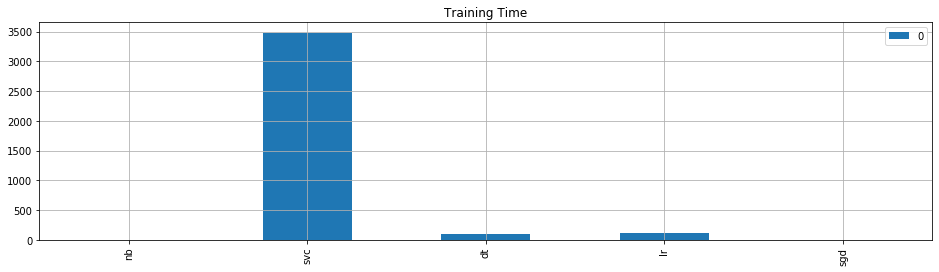

In [17]:
# model training time
time_df = pd.DataFrame.from_dict({'nb': 0.397, 'svc': 3480, 'dt': 101, 'lr': 121, 'sgd': 4}, orient='index')
time_df.plot(kind='bar', grid=True, figsize=(16,4), title='Training Time')

In [18]:
# model accuracy
cr_df = pd.DataFrame.from_dict(cr, orient='index')

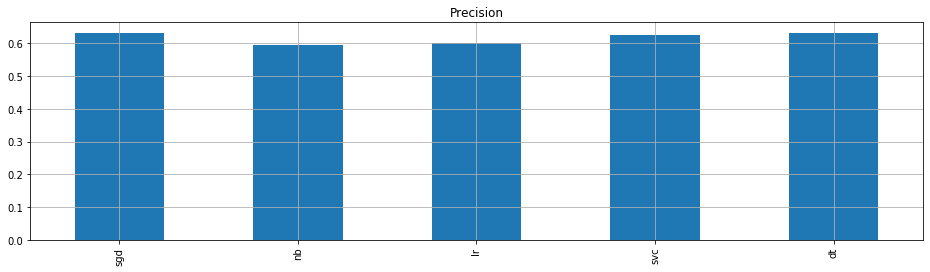

In [19]:
cr_df['precision'].plot(kind='bar', grid=True, figsize=(16,4), title='Precision')

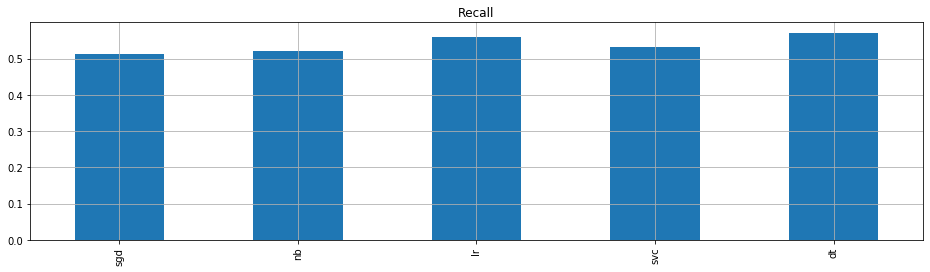

In [20]:
cr_df['recall'].plot(kind='bar', grid=True, figsize=(16,4), title='Recall')

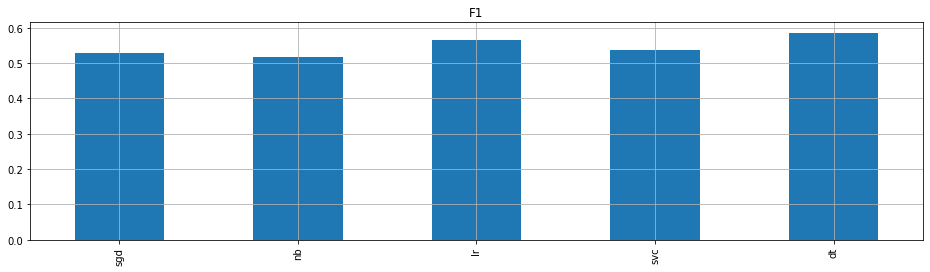

In [21]:
cr_df['f1-score'].plot(kind='bar', grid=True, figsize=(16,4), title='F1')

In [22]:
# compute % difference to the best
cr_df_perc = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'support'])
cr_df_perc.loc['nb'] = (cr_df.loc['nb'] - cr_df.loc['dt']) / cr_df.loc['dt'] * 100
cr_df_perc.loc['sgd'] = (cr_df.loc['sgd'] - cr_df.loc['dt']) / cr_df.loc['dt'] * 100
cr_df_perc.loc['svc'] = (cr_df.loc['svc'] - cr_df.loc['dt']) / cr_df.loc['dt'] * 100
cr_df_perc.loc['lr'] = (cr_df.loc['lr'] - cr_df.loc['dt']) / cr_df.loc['dt'] * 100
cr_df_perc.loc['dt'] = (cr_df.loc['dt'] - cr_df.loc['dt']) / cr_df.loc['dt'] * 100

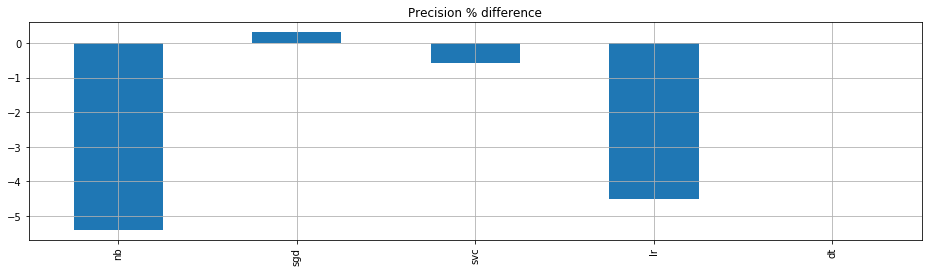

In [23]:
# plot % differences
cr_df_perc['precision'].plot(kind='bar', grid=True, figsize=(16, 4), title='Precision % difference')

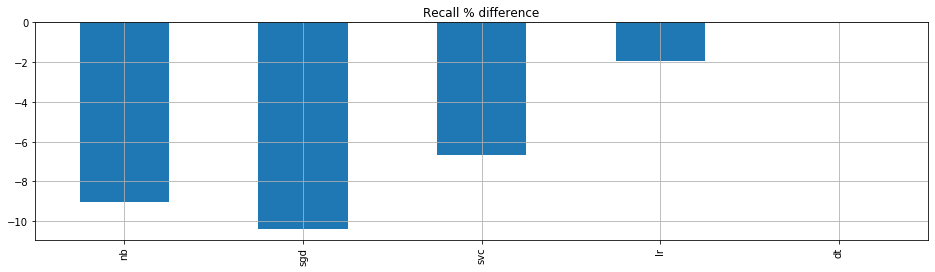

In [24]:
cr_df_perc['recall'].plot(kind='bar', grid=True, figsize=(16, 4), title='Recall % difference')

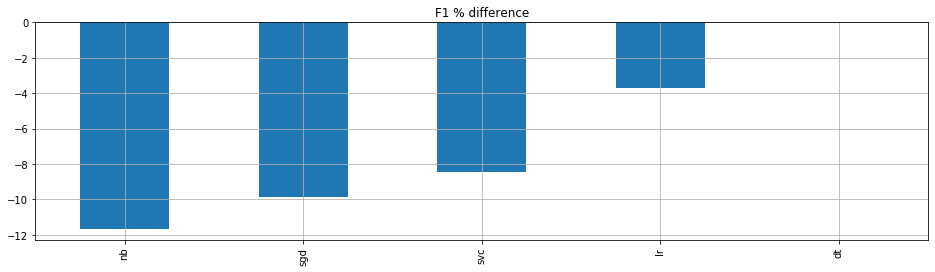

In [25]:
cr_df_perc['f1-score'].plot(kind='bar', grid=True, figsize=(16, 4), title='F1 % difference')

In [26]:
# Conditional Random Fields

# create sentences
def create_sentences(data):
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                      s['POS'].values.tolist(),
                                                      s['Tag'].values.tolist())]
    grouped = data.groupby('Sentence #').apply(agg_func)
    sentences = [s for s in grouped]
    return sentences

# create CRF input sentences
sentences = create_sentences(data)

In [27]:
print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [28]:
# feature extraction
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [29]:
# create input and output training data
x = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

# 1st sentence - text format
sentence_txt = ' '.join([it[0] for it in sentences[0]]) + '\n'
print(sentence_txt)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .



In [30]:
# 1st sentence - tuples and features
for s_item, x_item in zip(sentences[0], x[0]):
    print('sentence item: {}'.format(s_item))
    print('x_item: {}\n'.format(x_item))

sentence item: ('Thousands', 'NNS', 'O')
x_item: {'bias': 1.0, 'word.lower()': 'thousands', 'word[-3:]': 'nds', 'word[-2:]': 'ds', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NNS', 'postag[:2]': 'NN', 'BOS': True, '+1:word.lower()': 'of', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'IN', '+1:postag[:2]': 'IN'}

sentence item: ('of', 'IN', 'O')
x_item: {'bias': 1.0, 'word.lower()': 'of', 'word[-3:]': 'of', 'word[-2:]': 'of', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'IN', 'postag[:2]': 'IN', '-1:word.lower()': 'thousands', '-1:word.istitle()': True, '-1:word.isupper()': False, '-1:postag': 'NNS', '-1:postag[:2]': 'NN', '+1:word.lower()': 'demonstrators', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'NNS', '+1:postag[:2]': 'NN'}

sentence item: ('demonstrators', 'NNS', 'O')
x_item: {'bias': 1.0, 'word.lower()': 'demonstrators', 'word[-3:]': 'ors', 'word[-2:

In [31]:
%%time
# train dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

# train default CRF model
model_crf = sklearn_crfsuite.CRF(algorithm='lbfgs', all_possible_transitions=True)
model_crf.fit(x_train, y_train)

# compute y_pred
y_pred = model_crf.predict(x_test)

CPU times: user 8.01 s, sys: 12 ms, total: 8.02 s
Wall time: 8.02 s


In [556]:
y_pred

[['O',
  'O',
  'O',
  'O',
  'B-per',
  'I-per',
  'O',
  'O',
  'O',
  'B-per',
  'I-per',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-org',
  'I-org',
  'O',
  'B-per',
  'I-per',
  'I-per',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'B-org',
  'I-org',
  'I-org',
  'I-org',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'B-org',
  'I-org',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'B-org',
  'I-org',
  'I-org',
  'I-org',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-gpe',
  'O',
  'B-gpe',
  'I-gpe',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-geo',
  'O',
  'O',
  'B-org',
  'O',
  'O',
  'O',

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


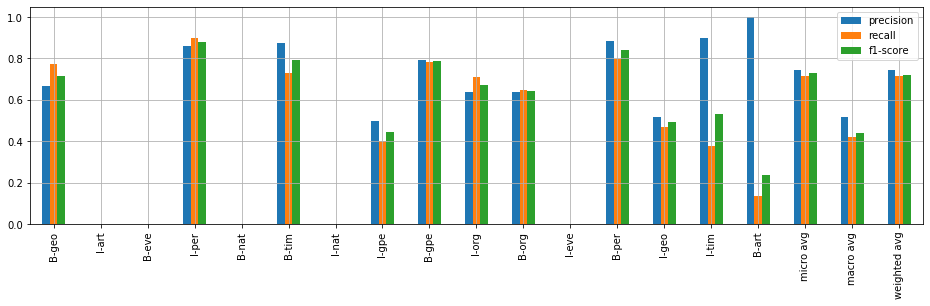

In [32]:
# compute classification report
report = metrics.flat_classification_report(y_pred=y_pred, y_true=y_test, labels=classes_without_o, output_dict=True)

# add CRF scores to overall classification report
cr['crf'] = report['weighted avg']

# convert classification report to Pandas dataframe
report_df = pd.DataFrame.from_dict(report, orient='index')

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(16, 4), grid=True)

In [33]:
# convert overall classification report to Pandas DataFrame
cr_df = pd.DataFrame.from_dict(cr, orient='index')

# compute % delta difference to CRF
cr_df_delta = pd.DataFrame(columns=['precision', 'recall', 'f1-score'])
cr_df_delta.loc['sgd'] = (cr_df.loc['sgd'] - cr_df.loc['crf']) / cr_df.loc['crf'] * 100
cr_df_delta.loc['nb'] = (cr_df.loc['nb'] - cr_df.loc['crf']) / cr_df.loc['crf'] * 100
cr_df_delta.loc['lr'] = (cr_df.loc['lr'] - cr_df.loc['crf']) / cr_df.loc['crf'] * 100
cr_df_delta.loc['svc'] = (cr_df.loc['svc'] - cr_df.loc['crf']) / cr_df.loc['crf'] * 100
cr_df_delta.loc['dt'] = (cr_df.loc['dt'] - cr_df.loc['crf']) / cr_df.loc['crf'] * 100
cr_df_delta.loc['crf'] = (cr_df.loc['crf'] - cr_df.loc['crf']) / cr_df.loc['crf'] * 100

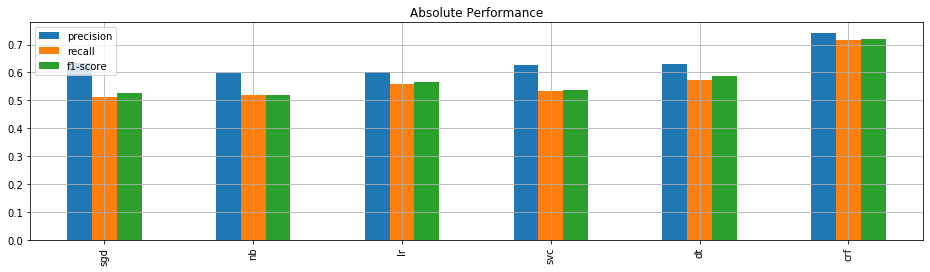

In [34]:
# plot absolute performance
cr_df[['precision', 'recall', 'f1-score']].plot(kind='bar', grid=True, figsize=(16,4), title='Absolute Performance')

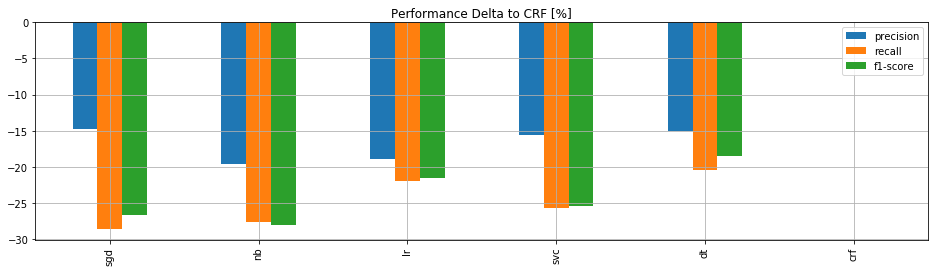

In [35]:
# plot performance delta
cr_df_delta.plot(kind='bar', grid=True, figsize=(16, 4), title='Performance Delta to CRF [%]')

In [36]:
# model training time
time_data = {'nb': 0.397, 'svc': 3480, 'dt': 101, 'lr': 121, 'sgd': 4, 'crf': 4.9}
time_df = pd.DataFrame.from_dict(time_data, orient='index')

# rename default column name - 0 - to 'training time'
time_df = time_df.rename(columns={0: 'Training Time [sec]'})

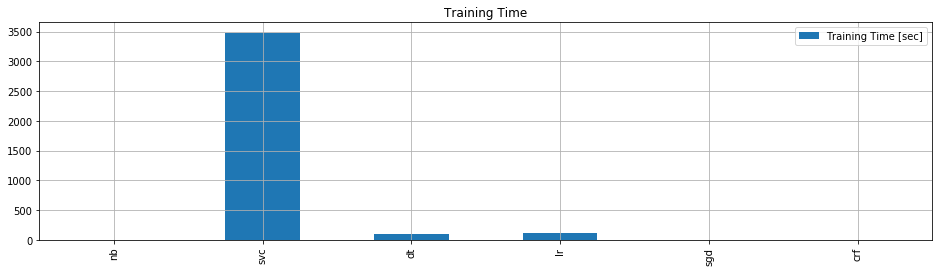

In [37]:
# plot training time
time_df.plot(kind='bar', grid=True, figsize=(16, 4), title='Training Time')

In [38]:
def compute_algorithm_efficiency(time_data, threshold):
    # initialize performance dictionary
    performance_per_time = {}

    # compute performance per time
    for k, v in time_data.items():
        if cr[k]['f1-score'] >= threshold:
            performance_per_time[k] = cr[k]['f1-score'] / time_data[k]

    # create performance per time dataframe
    performance_per_time_df = pd.DataFrame.from_dict(performance_per_time, orient='index')
    performance_per_time_df = performance_per_time_df.rename(columns={0: 'Performance Per Time: F1 Score / Training Time[sec]'})
    
    return performance_per_time_df

In [39]:
# compute algorithm efficiency - without a threshold
performance_per_time_no_threshold = compute_algorithm_efficiency(time_data, 0.0)

In [40]:
# compute algorithm efficiency - with a 0.55 threshold
performance_per_time_threshold = compute_algorithm_efficiency(time_data, 0.55)

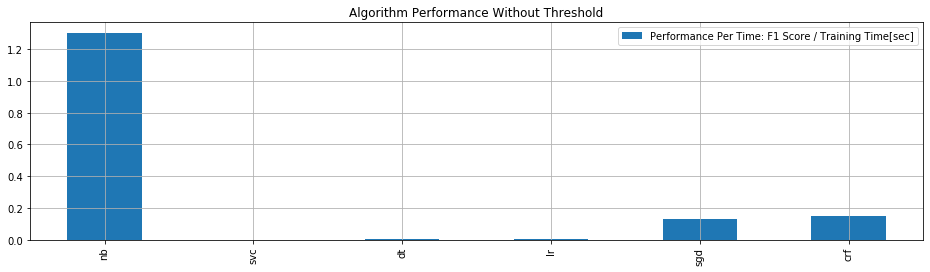

In [41]:
# plot algorithm performance - without a threshold
performance_per_time_no_threshold.plot(kind='bar', grid=True, figsize=(16, 4), title='Algorithm Performance Without Threshold')

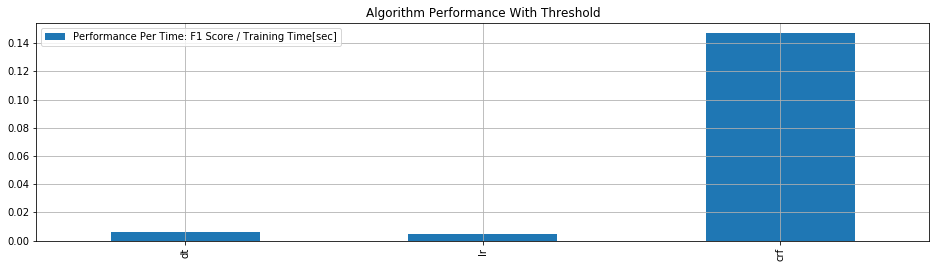

In [42]:
# plot algorithm performance - with threshold
performance_per_time_threshold.plot(kind='bar', grid=True, figsize=(16, 4), title='Algorithm Performance With Threshold')

In [43]:
# hyper-parameter tunning
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

In [44]:
# define parameter search space
scale_c1 = 0.2
scale_c2 = 0.2

# define parameter discributions
param_space = {
    'c1': scipy.stats.expon(scale=scale_c1),
    'c2': scipy.stats.expon(scale=scale_c2)
}

# use the same metric for evaluation like we did for the previous algorithms
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=classes_without_o)

# search for the best parameters
rs = RandomizedSearchCV(model_crf, param_space, cv=3, n_jobs=-1, n_iter=1000, scoring=f1_scorer)

In [45]:
%%time
# fit the model
rs.fit(x_train, y_train)

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CPU times: user 1h 55min 2s, sys: 4.38 s, total: 1h 55min 6s
Wall time: 3h 44min 3s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff403d13dd0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, l

In [46]:
print('best params:', rs.best_params_)
print('best CV scores: ', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_/1000000))

model_crf_tuned = rs.best_estimator_
y_pred = model_crf_tuned.predict(x_test)

report = metrics.flat_classification_report(y_pred=y_pred, y_true=y_test, labels=classes_without_o, output_dict=True)

cr['crf_tuned'] = report['weighted avg']

best params: {'c1': 0.004212682251657764, 'c2': 0.141785900234215}
best CV scores:  0.7207238078508665
model size: 0.70M


In [47]:
# visualize parameter space
font = {'family': 'normal', 'size': 10}
plt.rc('font', **font)

def plot_parameters(x, y, c, title=''):
    fig = plt.figure()
    fig.set_size_inches(6,6)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('C1')
    ax.set_xlabel('C2')
    ax.set_title(title)
    
    if len(x) == len(c):
        ax.scatter(x, y, c=c, s=15, alpha=0.9)
    else:
        plt.plot(x, y, marker='.', color='k', linestyle='none')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


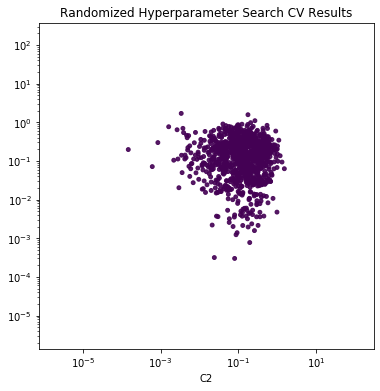

In [48]:
# plot search points without fitness score
x = [_ for _ in rs.cv_results_['param_c1']]
y = [_ for _ in rs.cv_results_['param_c2']]
c = [0.5 for _ in rs.cv_results_['mean_test_score']]

# plot parameters
plot_parameters(x, y, c, 'Randomized Hyperparameter Search CV Results')

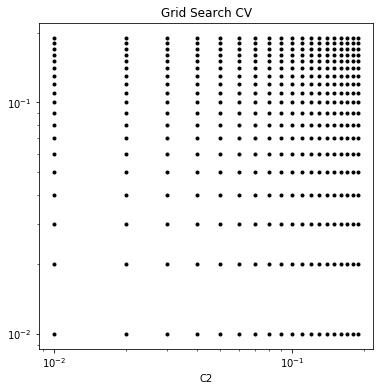

In [49]:
# grid search
_x = np.arange(0, scale_c1, scale_c1 / 20)
_y = np.arange(0, scale_c2, scale_c2 / 20)

x, y = np.meshgrid(_x, _y)

x_ = np.hstack(x) # convert to 1-dimension array
y_ = np.hstack(y) # convert to 1-dimension array
c = [0.0 for _ in _x]

# plot parameters - grid format
plot_parameters(x_, y_, c=c, title='Grid Search CV')

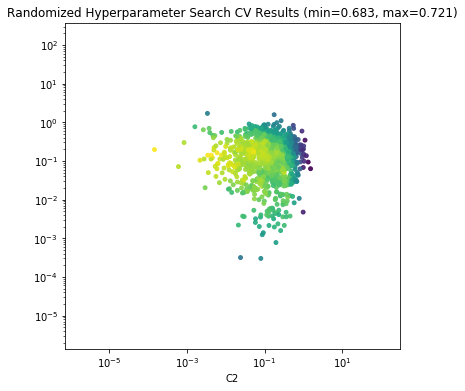

In [50]:
_x = [_ for _ in rs.cv_results_['param_c1']]
_y = [_ for _ in rs.cv_results_['param_c2']]
_c = [_ for _ in rs.cv_results_['mean_test_score']]

# plot parameters - hypertuning
plot_parameters(_x, _y, _c, title="Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(min(_c), max(_c)))

In [51]:
# performance compare
# convert overall classification report to Pandas DataFrame
cr_df = pd.DataFrame.from_dict(cr, orient='index')

# compute % delta difference to CRF
cr_df_delta = pd.DataFrame(columns=['precision', 'recall', 'f1-score'])
cr_df_delta.loc['sgd'] = (cr_df.loc['sgd'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100
cr_df_delta.loc['nb'] = (cr_df.loc['nb'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100
cr_df_delta.loc['lr'] = (cr_df.loc['lr'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100
cr_df_delta.loc['svc'] = (cr_df.loc['svc'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100
cr_df_delta.loc['dt'] = (cr_df.loc['dt'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100
cr_df_delta.loc['crf'] = (cr_df.loc['crf'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100
cr_df_delta.loc['crf_tuned'] = (cr_df.loc['crf_tuned'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100

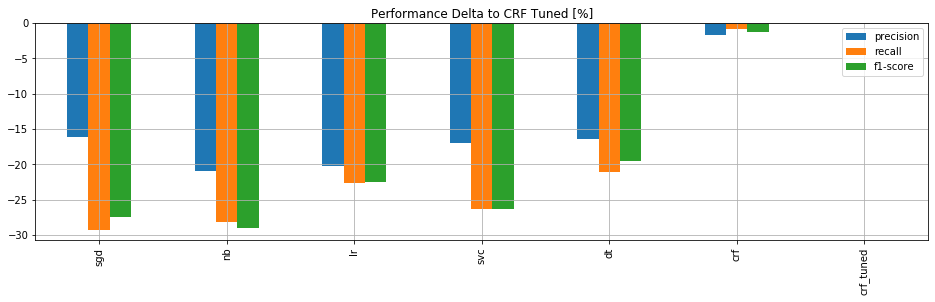

In [52]:
# plot absolute performance
cr_df_delta.plot(kind='bar', grid=True, figsize=(16, 4), title='Performance Delta to CRF Tuned [%]')

# add training time for CRF tuned
time_data['crf_tuned'] = 720

In [53]:
# compute efficiency - with a 0.55 threshold
performance_per_time_threshold = compute_algorithm_efficiency(time_data, 0.55)

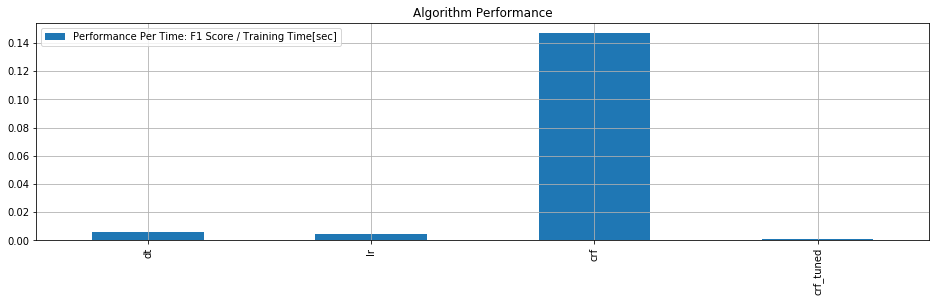

In [54]:
# plot algorithm performance
performance_per_time_threshold.plot(kind='bar', grid=True, figsize=(16, 4), title='Algorithm Performance')

In [97]:
# learned transitions
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.3f" % (label_from, label_to, weight))

In [99]:
from collections import Counter

print("Top likely transitions:")
print_transitions(Counter(model_crf_tuned.transition_features_).most_common(20))

Top likely transitions:
I-org  -> I-org   5.297
B-org  -> I-org   5.168
B-geo  -> I-geo   4.793
B-tim  -> I-tim   4.756
B-per  -> I-per   4.718
I-per  -> I-per   4.550
I-tim  -> I-tim   4.329
O      -> O       3.902
B-gpe  -> I-gpe   3.748
I-geo  -> I-geo   3.481
B-art  -> I-art   3.447
B-eve  -> I-eve   3.202
I-art  -> I-art   3.156
O      -> B-per   2.663
I-gpe  -> I-gpe   2.563
B-nat  -> I-nat   2.390
I-eve  -> I-eve   2.225
O      -> B-org   2.178
B-org  -> B-art   2.022
B-gpe  -> B-org   1.989


In [102]:
print("Top unlikely transitions:")
print_transitions(Counter(model_crf_tuned.transition_features_).most_common()[-20:])

Top unlikely transitions:
B-gpe  -> I-org   -0.968
B-gpe  -> I-geo   -0.991
I-tim  -> B-tim   -0.993
B-org  -> I-geo   -1.025
O      -> I-gpe   -1.034
B-org  -> I-per   -1.108
B-geo  -> I-per   -1.111
B-tim  -> B-gpe   -1.149
B-geo  -> I-gpe   -1.164
I-org  -> I-per   -1.216
B-tim  -> B-tim   -1.234
B-org  -> B-org   -1.326
O      -> I-art   -1.368
I-per  -> B-per   -1.512
B-per  -> B-per   -1.751
O      -> I-per   -1.769
B-gpe  -> B-gpe   -2.047
O      -> I-geo   -2.074
O      -> I-org   -2.564
O      -> I-tim   -2.660


In [103]:
# check state features
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.2f %-8s %s" % (weight, label, attr))

In [104]:
print("Top positive:")
print_state_features(Counter(model_crf_tuned.state_features_).most_common(20))

Top positive:
4.82 O        bias
4.28 B-tim    word[-2:]:0s
3.93 O        BOS
3.89 B-tim    word[-2:]:ay
3.86 B-tim    word[-3:]:day
2.84 B-per    +1:word.lower():administration
2.83 B-gpe    word.istitle()
2.75 O        word.lower():israeli-palestinian
2.71 B-per    BOS
2.68 B-org    word.lower():al-qaida
2.56 B-tim    word[-3:]:ber
2.56 B-tim    -1:word.lower():year
2.54 B-org    word.lower():hamas
2.53 B-tim    +1:word.lower():year
2.36 I-tim    word[-2:]:ay
2.32 B-gpe    -1:word.lower():recognize
2.31 B-tim    word.lower():by-election
2.29 B-geo    word.lower():second-in-command
2.26 O        -1:word.lower():prime
2.16 B-org    word[-3:]:ban


In [105]:
print("Top negative:")
print_state_features(Counter(model_crf_tuned.state_features_).most_common()[-20:])

Top negative:
-1.35 O        -1:word.lower():first
-1.38 O        +1:word.lower():officials
-1.38 O        -1:word.lower():before
-1.39 O        +1:word.lower():saturday
-1.47 O        word[-2:]:ni
-1.50 I-per    +1:postag[:2]:NN
-1.59 B-geo    word[-2:]:er
-1.63 O        +1:word.lower():term
-1.70 B-art    -1:word.istitle()
-1.73 O        word.lower():later
-1.83 O        +1:word.lower():year
-1.84 O        +1:word.lower():years
-1.99 O        -1:word.lower():parliamentary
-2.16 O        postag[:2]:NN
-2.19 O        -1:word.lower():year
-2.45 O        +1:word.lower():months
-2.60 O        word.isupper()
-2.69 O        word.isdigit()
-3.76 O        word.istitle()
-3.78 O        postag:NNP


In [106]:
import eli5

# inspect model weights
eli5.show_weights(model_crf, top=10)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.144,0.736,-1.007,0.71,-0.696,1.323,-1.408,1.088,-0.742,0.236,-0.578,1.588,-1.859,1.697,-1.186,1.578,-1.923
B-art,-0.429,-0.031,2.403,-0.024,-0.136,-0.119,-0.216,-0.133,-0.153,-0.021,-0.081,-0.173,-0.246,-0.274,-0.343,0.08,-0.168
I-art,-0.429,-0.028,2.205,-0.019,-0.097,-0.151,-0.17,-0.121,-0.099,-0.02,-0.067,-0.127,-0.203,-0.324,-0.333,-0.148,-0.095
B-eve,-0.517,-0.026,-0.144,-0.029,2.255,-0.116,-0.201,-0.141,-0.139,-0.019,-0.066,-0.152,-0.255,-0.265,-0.29,-0.16,-0.107
I-eve,-0.46,-0.011,-0.075,-0.018,1.311,-0.049,-0.086,-0.064,-0.06,-0.016,-0.038,-0.08,-0.111,-0.165,-0.195,-0.077,-0.063
B-geo,0.105,-0.081,-0.561,-0.083,-0.438,-0.33,3.472,0.601,-0.621,-0.075,-0.309,-0.446,-0.714,-0.472,-0.871,0.782,-0.561
I-geo,-0.107,-0.032,-0.196,-0.027,-0.132,-0.167,2.19,-0.105,-0.138,-0.028,-0.094,-0.139,-0.287,-0.392,-0.376,-0.113,-0.186
B-gpe,0.755,-0.132,-0.404,-0.103,-0.311,-0.489,-0.657,-0.939,2.527,-0.076,-0.206,1.152,-0.733,0.426,-0.635,-0.441,-0.502
I-gpe,-0.35,-0.016,-0.064,-0.009,-0.042,-0.091,-0.064,-0.075,1.249,-0.01,-0.029,-0.068,-0.125,-0.205,-0.163,-0.071,-0.056
B-nat,-0.557,-0.014,-0.086,-0.011,-0.066,-0.081,-0.108,-0.079,-0.074,-0.013,1.494,-0.097,-0.119,-0.175,-0.214,-0.145,-0.065


In [108]:
# check only a subset of tags
eli5.show_weights(model_crf, top=10, targets=['B-geo', 'I-tim', 'B-per'])

In [109]:
# check only some of the features for all tags
eli5.show_weights(model_crf, top=10, feature_re='^word\.is', horizontal_layout=False, show=['targets'])

Weight?,Feature
-1.607,word.isupper()
-1.655,word.isdigit()
-2.924,word.istitle()
Weight?,Feature
+0.083,word.isupper()
-0.092,word.isdigit()
-0.093,word.istitle()
Weight?,Feature
+0.309,word.isdigit()
+0.038,word.istitle()


In [642]:
# fix strange character
raw_data.loc[1786].Word = 'is'

# split raw data into train and test
x_train, x_test, y_train, y_test = train_test_split(raw_data[['Word', 'POS']], raw_data['Tag'], test_size=0.2, random_state=3)

# create train data by adding "y_train" column
train_data = x_train.join(y_train)

# create test data by adding "y_test" column
test_data = x_test.join(y_test)

# select only useful columns: Word & Tag
train_data = train_data[['Word', 'POS', 'Tag']]
test_data = test_data[['Word', 'POS', 'Tag']]

# save train & test data to csv files
train_data.to_csv('train_data.iob', sep='\t', index=False, header=False)
test_data.to_csv('test_data.iob', sep='\t', index=False, header=False)

In [643]:
import subprocess

# method for running shell commands
def run_command(cmd):
    return subprocess.run(cmd, capture_output=True, encoding='utf-8', shell='True')

In [644]:
# convert train & test data from IOB format to JSON format
convert_train_data = 'python -m spacy convert -c iob train_data.iob . -s'
convert_test_data = 'python -m spacy convert -c iob test_data.iob . -s'

# run commands
p1 = run_command(convert_train_data)
p2 = run_command(convert_test_data)

print(p1)
print(p2)

CompletedProcess(args='python -m spacy convert -c iob train_data.iob . -s', returncode=0, stdout='\x1bℹ Auto-detected token-per-line NER format\x1b\n\x1bℹ Grouping every 1 sentences into a document.\x1b\n\x1b⚠ To generate better training data, you may want to group sentences\ninto documents with `-n 10`.\x1b\n\x1bℹ Segmenting sentences with sentencizer. (Use `-b model` for improved\nparser-based sentence segmentation.)\x1b\n\x1b✔ Generated output file (1004 documents): train_data.json\x1b\n', stderr='')
CompletedProcess(args='python -m spacy convert -c iob test_data.iob . -s', returncode=0, stdout='\x1bℹ Auto-detected token-per-line NER format\x1b\n\x1bℹ Grouping every 1 sentences into a document.\x1b\n\x1b⚠ To generate better training data, you may want to group sentences\ninto documents with `-n 10`.\x1b\n\x1bℹ Segmenting sentences with sentencizer. (Use `-b model` for improved\nparser-based sentence segmentation.)\x1b\n\x1b✔ Generated output file (283 documents): test_data.json\x1b\

In [614]:
%%time
train_cmd = 'python -m spacy train en . train_data.json test_data.json -p ner -n 100'
p3 = run_command(train_cmd)

print(p3)

CompletedProcess(args='python -m spacy train en . train_data.json test_data.json -p ner -n 100', returncode=1, stdout="\x1b⚠ Output directory is not empty\x1b\nThis can lead to unintended side effects when saving the model. Please use an\nempty directory or a different path instead. If the specified output path\ndoesn't exist, the directory will be created for you.\nTraining pipeline: ['ner']\nStarting with blank model 'en'\nCounting training words (limit=0)\n\nItn  NER Loss   NER P   NER R   NER F   Token %  CPU WPS\n---  ---------  ------  ------  ------  -------  -------\n  1   4527.209  40.745  39.282  40.000  100.000    36264\n  2   2769.158  57.474  55.668  56.556  100.000    37591\n  3   2120.626  63.584  62.514  63.045  100.000    36966\n  4   1650.859  65.632  64.085  64.850  100.000    37602\n  5   1362.884  67.890  66.442  67.158  100.000    36949\n  6   1133.197  67.800  67.116  67.456  100.000    38266\n  7    911.518  67.431  65.993  66.704  100.000    37702\n  8    746.2

In [615]:
# read performance scores
with open('model-final/meta.json') as f:
    score = json.loads(f.read())
    
# store performance scores
cr['spacy'] = {'precision': score['accuracy']['ents_p'] / 100, 
               'recall': score['accuracy']['ents_r'] / 100,
               'f1-score': score['accuracy']['ents_f'] / 100}

# convert overall classification report to Pandas
cr_df = pd.DataFrame.from_dict(cr, orient='index')

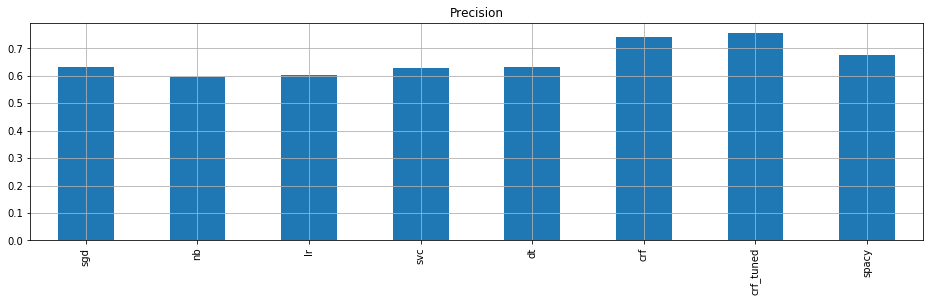

In [616]:
cr_df['precision'].plot(kind='bar', grid=True, figsize=(16,4), title='Precision')

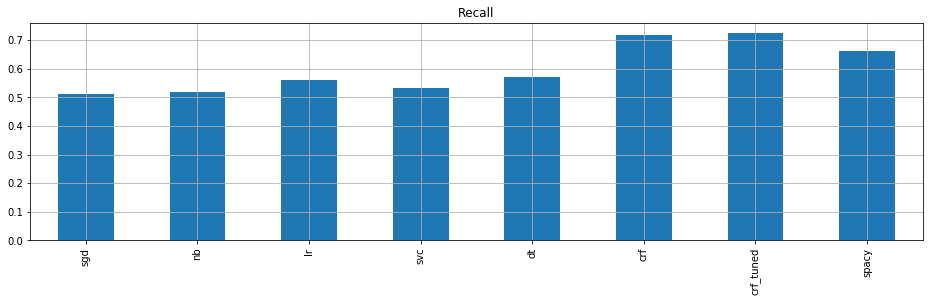

In [617]:
cr_df['recall'].plot(kind='bar', grid=True, figsize=(16,4), title='Recall')

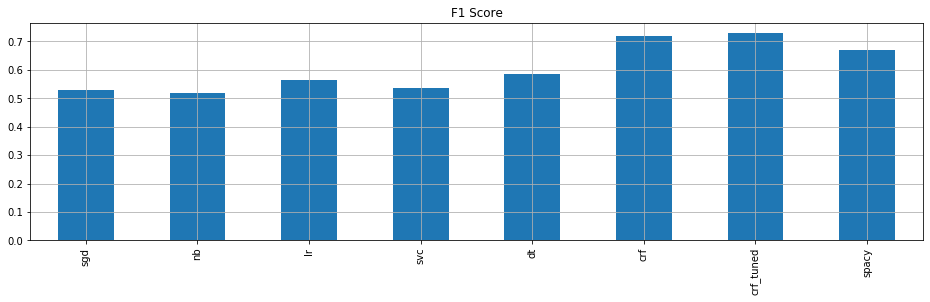

In [618]:
cr_df['f1-score'].plot(kind='bar', grid=True, figsize=(16,4), title='F1 Score')

In [619]:
# compute performance delta in %
cr_df_delta.loc['spacy'] = (cr_df.loc['spacy'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned'] * 100

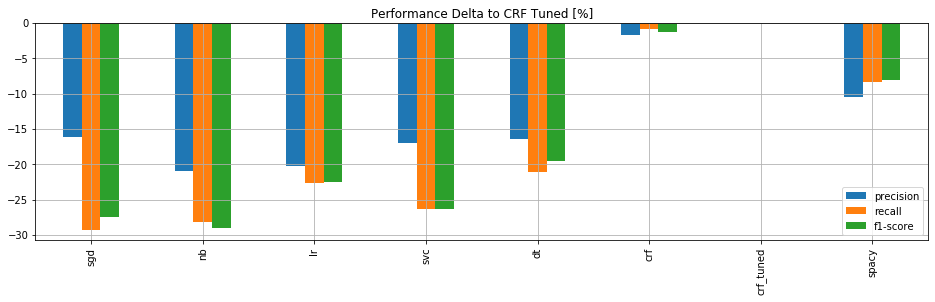

In [620]:
# plot absolute performance
cr_df_delta.plot(kind='bar', grid=True, figsize=(16,4), title='Performance Delta to CRF Tuned [%]')

In [628]:
# add training time for CRF tuned
time_data['spacy'] = 262 # seconds

In [629]:
# compute efficiency with a 0.55 threshold
performance_per_time_threshold = compute_algorithm_efficiency(time_data, 0.55)

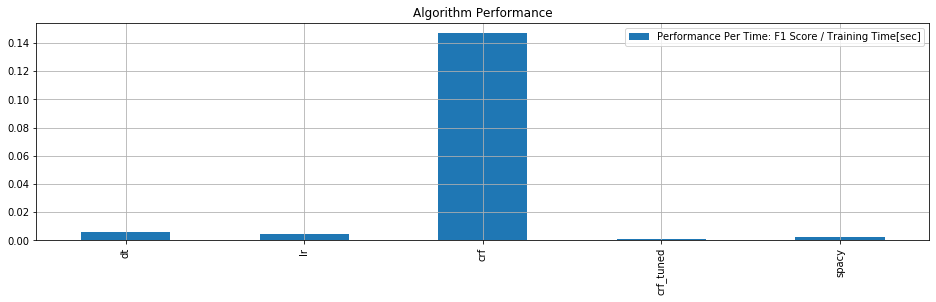

In [630]:
# plot algorithm performance
performance_per_time_threshold.plot(kind='bar', grid=True, figsize=(16,4), title='Algorithm Performance')

In [631]:
# load trained model from 'model-final' folder
nlp2 = spacy.load('model-final')

In [645]:
sentence_idx = 455

# retrieve sentence text
sentence_txt = ' '.join([it[0] for it in sentences[sentence_idx]])

print('Sentence text: ', sentence_txt)

print(sentences[sentence_idx])

Sentence text:  The FAO 's estimate includes damage to fishing industries in Indonesia , Maldives , Somalia , Sri Lanka and Thailand .
[('The', 'DT', 'O'), ('FAO', 'NNP', 'B-org'), ("'s", 'POS', 'O'), ('estimate', 'NN', 'O'), ('includes', 'VBZ', 'O'), ('damage', 'NN', 'O'), ('to', 'TO', 'O'), ('fishing', 'NN', 'O'), ('industries', 'NNS', 'O'), ('in', 'IN', 'O'), ('Indonesia', 'NNP', 'B-geo'), (',', ',', 'O'), ('Maldives', 'NNP', 'B-geo'), (',', ',', 'O'), ('Somalia', 'NNP', 'B-geo'), (',', ',', 'O'), ('Sri', 'NNP', 'B-geo'), ('Lanka', 'NNP', 'I-geo'), ('and', 'CC', 'O'), ('Thailand', 'NNP', 'B-geo'), ('.', '.', 'O')]


In [633]:
# create input and output training data
x = [sent2features(s) for s in [sentences[sentence_idx]]]

In [634]:
# run CRF model
crf_tokens = model_crf_tuned.predict(x)

In [635]:
# print NER tokens for CRF
print('CRF NER: ', [(w[0], t) for w,t in zip(sentences[sentence_idx], crf_tokens[0])])

CRF NER:  [('The', 'O'), ('FAO', 'B-org'), ("'s", 'O'), ('estimate', 'O'), ('includes', 'O'), ('damage', 'O'), ('to', 'O'), ('fishing', 'O'), ('industries', 'O'), ('in', 'O'), ('Indonesia', 'B-geo'), (',', 'O'), ('Maldives', 'B-geo'), (',', 'O'), ('Somalia', 'B-geo'), (',', 'O'), ('Sri', 'B-geo'), ('Lanka', 'I-geo'), ('and', 'O'), ('Thailand', 'B-geo'), ('.', 'O')]


In [636]:
# run SpaCy
doc = model_spacy(sentence_txt)

In [637]:
# print NER tokens for SpaCy
print('SpaCy NER: ', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

SpaCy NER:  [('The', '', 2), ('FAO', 'org', 3), ("'s", '', 2), ('estimate', '', 2), ('includes', '', 2), ('damage', '', 2), ('to', '', 2), ('fishing', '', 2), ('industries', '', 2), ('in', '', 2), ('Indonesia', 'geo', 3), (',', '', 2), ('Maldives', 'per', 3), (',', '', 2), ('Somalia', 'geo', 3), (',', '', 2), ('Sri', 'per', 3), ('Lanka', 'gpe', 3), ('and', '', 2), ('Thailand', 'geo', 3), ('.', '', 2)]


In [640]:
from spacy import displacy

displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...



----------------------------------------
Exception happened during processing of request from ('185.151.243.193', 54534)
Traceback (most recent call last):
  File "/usr/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/lib/python3.7/wsgiref/simple_server.py", line 118, in handle
    self.raw_requestline = self.rfile.readline(65537)
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 104] Connection reset by peer
----------------------------------------
185.202.2.149 - - [25/May/2020 23:41:04] code 4

Shutting down server on port 5000.
